In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

df = pd.read_csv("data/bicycle.txt", names=['x', 'y'], delimiter=" ")
SAMPLES = len(df)

def take_sample_batch(points: torch.Tensor, sample_size: int = 1000) -> torch.Tensor:
    sample_idx = torch.randint(0, SAMPLES, (sample_size, ))
    return points[sample_idx]

def plot_points(points: torch.Tensor) -> None:
    plt.scatter(points[:, 0], points[:, 1])
    plt.axis("off")
    plt.show()

### Rozkład danych wejściowych

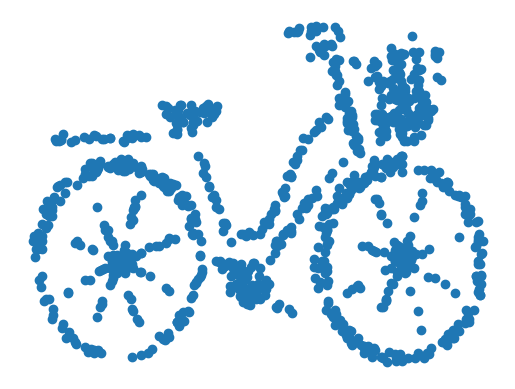

In [2]:
x_series, y_series = df["x"], df["y"]
x, y = torch.Tensor(x_series), torch.Tensor(y_series)
points = torch.stack((x, y)).transpose(0, 1)
plot_points(take_sample_batch(points))

### Originalne parametry przy linear schedule

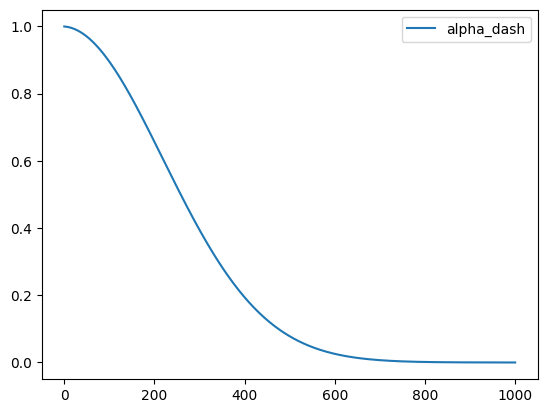

In [3]:
betas = torch.linspace(0.0001, 0.02, 1001).reshape(-1, 1)
alphas = 1 - betas
alphas_dash = torch.cumprod(alphas, 0)

plt.plot(alphas_dash, label="alpha_dash")
plt.legend()
plt.show()

### Sigmoidka przekształcona

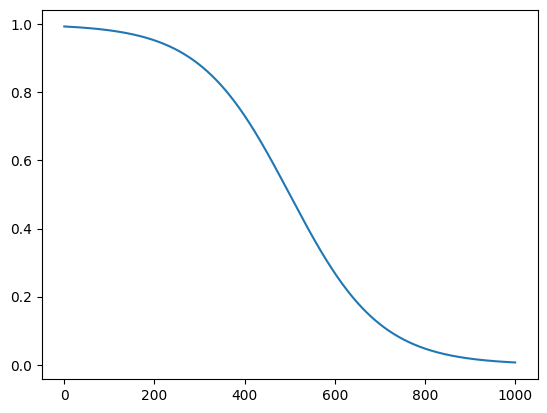

In [4]:
import matplotlib.pyplot as plt


def sigmoid(x, k=10):
    s = 1 / (1 + torch.exp((x - 0.5)*k)) 
    return s

x = torch.linspace(0,1,1001).reshape(-1, 1)
new_alphas = sigmoid(x)
plt.plot(new_alphas)
plt.show()

### Nowe parametry

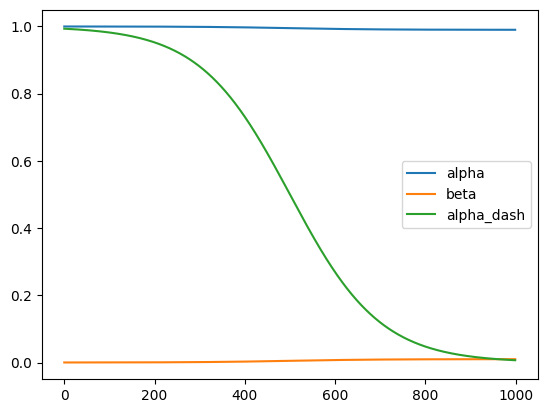

In [5]:
alphas = new_alphas[1:] / new_alphas[:-1]
betas = 1 - alphas
alphas_dash = new_alphas[:-1]

plt.plot(alphas, label="alpha")
plt.plot(betas, label="beta")
plt.plot(alphas_dash, label="alpha_dash")
plt.legend()
plt.show()

### Proces forward diffusion

In [6]:
random_batch = take_sample_batch(points, 1000)

In [7]:
def forward(batch: torch.Tensor, ts: int):

    alpha_ts = alphas_dash[ts]
    mean_ts = batch * torch.sqrt(alpha_ts)
    variance = (1 - alpha_ts)*torch.randn_like(mean_ts)
    batch_ts = mean_ts + variance
    return batch_ts

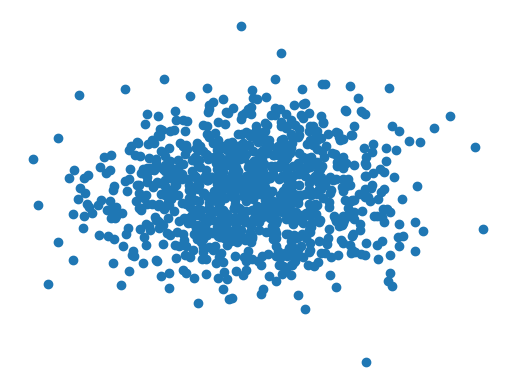

In [8]:
from IPython.display import clear_output

for i in range(0, 1000, 5):
    batch_i = forward(random_batch, i)
    plot_points(batch_i)
    clear_output(wait=True)

In [68]:
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()

        position = torch.arange(1000).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 50, 2) * (-torch.math.log(10000.0) / 50))

        self.pos_encoding = torch.zeros(1000, 50)
        self.pos_encoding[:, 0::2] = torch.sin(position * div_term)
        self.pos_encoding[:, 1::2] = torch.cos(position * div_term)

        self.embedding = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

    def forward(self, ts: torch.Tensor) -> torch.Tensor:
        return self.embedding(self.pos_encoding[ts])
    

class Diffusion(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.ts_embeddings = PositionalEncoding()

        self.linear1 = nn.Linear(2, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 2)
        self.relu = nn.ReLU()


    def forward(self, x: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        ts_encoding = self.ts_embeddings(ts)

        x = self.relu(self.linear1(x) + ts_encoding)
        x = self.relu(self.linear2(x) + ts_encoding)
        x = self.relu(self.linear3(x) + ts_encoding)
        x = self.linear4(x)

        return x


Epoch 10
Loss: 0.45557885776673046
Epoch 20
Loss: 0.4533661924851393
Epoch 30
Loss: 0.45421383862416925
Epoch 40
Loss: 0.4218110968465252
Epoch 50
Loss: 0.45107622650784573
Epoch 60
Loss: 0.45937949083612434
Epoch 70
Loss: 0.4258522538059125
Epoch 80
Loss: 0.4168838562300828
Epoch 90
Loss: 0.46518095178163743
Epoch 100
Loss: 0.4287034218758345
Epoch 110
Loss: 0.4472185466554947
Epoch 120
Loss: 0.39684249386523984
Epoch 130
Loss: 0.44747122166611786
Epoch 140
Loss: 0.4179278709050933
Epoch 150
Loss: 0.42585694579074956
Epoch 160
Loss: 0.4046408780477941
Epoch 170
Loss: 0.42331746683189914
Epoch 180
Loss: 0.43311201287699597
Epoch 190
Loss: 0.44416663215262814
Epoch 200
Loss: 0.4339086170990153
Epoch 210
Loss: 0.4456384422397241
Epoch 220
Loss: 0.4238216770982503
Epoch 230
Loss: 0.4235848318173417
Epoch 240
Loss: 0.43235450780917223
Epoch 250
Loss: 0.436169558080645
Epoch 260
Loss: 0.40675951745793487
Epoch 270
Loss: 0.41372902692362135
Epoch 280
Loss: 0.42709015012752
Epoch 290
Loss: 0.

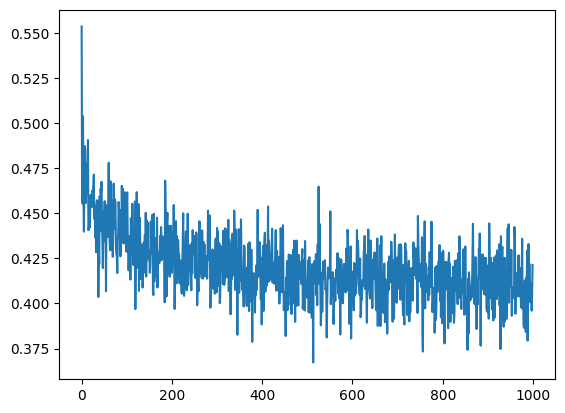

In [69]:
from torch.optim import Adam

net = Diffusion()
batch_size = 64
optimizer = Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

loss_values = []

for i in range(1000):
    epoch_loss = 0.0

    for j in range(700):

        batch = take_sample_batch(points, batch_size)
        t = torch.randint(0, 1000, (1, ))
        noise = torch.randn_like(batch)

        mean_ts = batch * torch.sqrt(alphas_dash[t])
        variance = (1 - alphas_dash[t])*noise
        batch_ts = mean_ts + variance

        out_batch = net(batch_ts, t)
        loss = criterion(out_batch, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1}")
        print(f"Loss: {epoch_loss / 700}")

    loss_values.append(epoch_loss / 700)

plt.plot(loss_values)

In [72]:
x_t = torch.randn(1000, 2)
net.eval()

for i in range(999, -1, -1):
    z = torch.randn_like(x_t) if i > 0 else torch.zeros_like(x_t)
    t = torch.tensor((i,))

    with torch.no_grad():
        out = net(x_t, t)

    out *= (1 - alphas[t]) / torch.sqrt(1 - alphas_dash[t])
    x_t = (1 / torch.sqrt(alphas[t])) * (x_t - out) + torch.sqrt(betas[t])*z

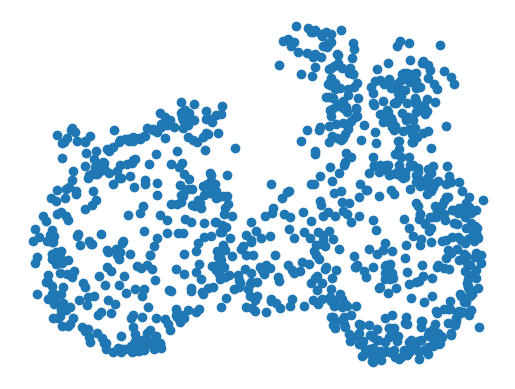

In [73]:
plot_points(x_t)